In [1]:
import sys
sys.path.append("..")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import cv2
import math
import copy
import torch
import torchvision 
import numpy as np
import nvdiffrast.torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

from scene import Scene
from scene.cameras import Camera
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import render
from gaussian_renderer import GaussianModel

from diff_surfel_2dgs import GaussianRasterizer as GaussianRasterizer_2dgs
from diff_surfel_2dgs import GaussianRasterizationSettings as GaussianRasterizationSettings_2dgs
from diff_surfel_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from diff_surfel_rasterization_real import GaussianRasterizationSettings as GaussianRasterizationSettings_real
from diff_surfel_rasterization_real import GaussianRasterizer as GaussianRasterizer_real

from utils.point_utils import depth_to_normal
from utils.color_utils import *
from utils.sph_utils import *

In [2]:
# From https://github.com/lzhnb/GS-IR
from PIL import Image
from lpips import LPIPS
from utils.loss_utils import ssim as get_ssim

def mse(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    return (((img1 - img2)) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)

def psnr(img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
    mse = (((img1 - img2)) ** 2).view(img1.shape[0], -1).mean(1, keepdim=True)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def get_mae(gt_normal_stack: np.ndarray, render_normal_stack: np.ndarray) -> float:
    MAE = np.mean(np.arccos(np.clip(np.sum(gt_normal_stack * render_normal_stack, axis=-1), -1, 1)) * 180 / np.pi)
    return MAE.item()

lpips_fn = LPIPS(net="vgg").cuda()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/xiao/anaconda3/envs/ref_gs/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiao/anaconda3/envs/ref_gs/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/xiao/anaconda3/envs/ref_gs/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
parser = ArgumentParser(description="Testing script parameters")
pipeline = PipelineParams(parser)
args = ModelParams(parser, sentinel=True)

import os

# NAME = 'sedan'
NAME = 'helmet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for small synthetic dataset
args.model_path = "../output/refnerf/" + NAME
args.source_path = "../data/refnerf/" + NAME

# for large real dataset
# args.model_path = "../output/ref-real/" + NAME
# args.source_path = "../data/ref-real/" + NAME

args.resolution = 1
args.images = "images"
args.white_background = False
args.data_device = "cpu"
args.model_device = device
args.eval = True

bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)

load_iteration = 30000

with torch.no_grad():
    gaussians = GaussianModel(args.sh_degree, args)
    scene = Scene(args, gaussians, load_iteration=load_iteration, shuffle=False)
    gaussians.sph_dim = 16
    gaussians.dim = 1
    
gaussians.light_mlp = torch.load(args.model_path + '/point_cloud/iteration_'+str(load_iteration)+'/light_mlp.pt')
gaussians.dir_encoding = torch.load(args.model_path + '/point_cloud/iteration_'+str(load_iteration)+'/dir_encoding.pt')

SphMipEncoding ### level: 9   size: 512
Loading trained model at iteration 30000
Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Generating random point cloud (100000)...
resolution_scales [1.0]
Loading Training Cameras


/home/xiao/anaconda3/envs/ref_gs/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading Test Cameras
Load Path ../output/refnerf/toaster/point_cloud/iteration_30000/point_cloud.ply


In [4]:
#### For real dataset
# Sedan
# ENV_CENTER = torch.tensor([-0.032,0.808,0.751], device='cuda')
# ENV_RADIUS = 2.138
# XYZ = [2, 1, 0]

# Gardenspheres
# ENV_CENTER = torch.tensor([-0.2270,  1.9700,  1.7740], device='cuda')
# ENV_RADIUS = 0.974
# XYZ = [2, 1, 0]

# # Toycar
# ENV_CENTER = torch.tensor([0.486, 1.108, 3.72], device='cuda')
# ENV_RADIUS = 2.507
# XYZ = [0, 2, 1]

In [5]:
use_feature = True

def get_outside_msk(xyz, ENV_CENTER, ENV_RADIUS):
    device = xyz.device
    ENV_CENTER = ENV_CENTER.to(device)
    ENV_RADIUS = torch.tensor(ENV_RADIUS, device=device) if not torch.is_tensor(ENV_RADIUS) else ENV_RADIUS.to(device)
    return torch.sum((xyz - ENV_CENTER[None])**2, dim=-1) > ENV_RADIUS**2

def render(viewpoint_camera, pc, pipe, bg_color, scaling_modifier=1.0, override_color=None, iteration=0):
    # Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
    screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
    try:
        screenspace_points.retain_grad()
    except:
        pass
    # Set up cuda or cpu device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)
    
    image_height = int(viewpoint_camera.image_height)
    image_width = int(viewpoint_camera.image_width)
    
    raster_settings_black = GaussianRasterizationSettings(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color*0.0,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform,
        projmatrix=viewpoint_camera.full_proj_transform,
        sh_degree=pc.active_sh_degree,
        campos=viewpoint_camera.camera_center,
        prefiltered=False,
        debug=False,
        include_feature=use_feature,
    )
    
    rasterizer_black = GaussianRasterizer(raster_settings=raster_settings_black)
    
    means3D = pc.get_xyz
    means2D = screenspace_points
    opacity = pc.get_opacity
    scales = pc.get_scaling
    rotations = pc.get_rotation
    shs = pc.get_features

    rets =  { }

    gs_albedo = pc.get_albedo
    gs_roughness = pc.get_roughness
    gs_feature = pc.get_language_feature

    input_ts = torch.cat([gs_roughness, gs_feature], dim=-1)
    
    albedo_map, out_ts, radii, allmap = rasterizer_black(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = gs_albedo,
        language_feature_precomp = input_ts,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = None
    )

    render_alpha = allmap[1:2]

    render_normal = allmap[2:5]
    render_normal = (render_normal.permute(1,2,0) @ (viewpoint_camera.world_view_transform[:3,:3].T)).permute(2,0,1)
    render_normal = F.normalize(render_normal, dim=0)

    render_depth_median = allmap[5:6]
    render_depth_median = torch.nan_to_num(render_depth_median, 0, 0)

    render_depth_expected = allmap[0:1]
    render_depth_expected = (render_depth_expected / render_alpha)
    render_depth_expected = torch.nan_to_num(render_depth_expected, 0, 0)

    render_dist = allmap[6:7]

    surf_depth = render_depth_expected * (1-pipe.depth_ratio) + (pipe.depth_ratio) * render_depth_median

    surf_normal = depth_to_normal(viewpoint_camera, surf_depth)
    surf_normal = surf_normal.permute(2,0,1)
    surf_normal = surf_normal * (render_alpha).detach()

    #####################################################################################################################
    rays_d = viewpoint_camera.rays_d.cuda()
    viewdirs = rays_d
    normals = render_normal.permute(1,2,0)
    wo = F.normalize(reflect(-viewdirs, normals), dim=-1)
    
    out_ts = out_ts.permute(1,2,0)
    
    albedo_map = albedo_map.permute(1,2,0)
    roughness_map = out_ts[..., :1]
    feature_map = out_ts[..., 1:]
    
    #####################################################################################################################
    with torch.no_grad():
        select_index = (render_alpha.reshape(-1,) > 0.05).nonzero(as_tuple=True)[0]
    
    wo = wo.reshape(-1, 3)[select_index]
    normals = normals.reshape(-1, 3)[select_index]
    roughness_map = roughness_map.reshape(-1, 1)[select_index]
    albedo_map = albedo_map.reshape(-1, 3)[select_index]
    
    feature_map = feature_map.reshape(-1, pc.gsfeat_dim)[select_index]
    feature_map = F.normalize(feature_map, dim=-1)
    
    feature_map = feature_map.reshape(-1, 1, pc.gsfeat_dim)
    feature_dirc = feature_map.reshape(-1, pc.gsfeat_dim)
    
    ''' Sph-Mip '''
    #####################################################################################################################
    
    wo_xy = (cart2sph(wo.reshape(-1, 3)[..., [0,1,2]])[..., 1:] / torch.Tensor([[np.pi, 2*np.pi]]).to(device))[..., [1,0]]
    wo_xyz = torch.stack([wo_xy[:, None, :]], dim=0,)
    
    spec_level = roughness_map.reshape(-1, 1)

    spec_feat = pc.dir_encoding(wo_xyz, spec_level.view(-1, 1), index=0).reshape(-1, pc.sph_dim)
    spec_feat_wrap = spec_feat.reshape(-1, pc.sph_dim, 1)
    spec_feat_dirc = spec_feat.reshape(-1, pc.sph_dim)
    
    #####################################################################################################################
    # Specular color
    wrap_input = (spec_feat_wrap @ feature_map).reshape(-1, pc.sph_dim*pc.gsfeat_dim)
    input_mlp = torch.cat([wrap_input, spec_feat_dirc], -1)
    mlp_output = pc.light_mlp(input_mlp).float()
    spec_light = torch.exp(torch.clamp(mlp_output, max=5.0))
    
    # Diffuse color
    diff_light = albedo_map
    
    pbr_rgb = spec_light + diff_light
    pbr_rgb = linear2srgb(pbr_rgb)
    pbr_rgb = torch.clamp(pbr_rgb, min=0., max=1.)
    #####################################################################################################################
    
    output_rgb = torch.zeros(image_height, image_width, 3).to(device)
    output_rgb.reshape(-1, 3)[select_index] = pbr_rgb
    output_rgb = output_rgb.permute(2,0,1)
    
    rets.update({
        'pred_rgb': output_rgb,
        'rend_alpha': render_alpha,
        'rend_normal': render_normal,
        'rend_dist': render_dist,
        'surf_depth': surf_depth,
        'feature': feature_map,
    })

    return rets



In [6]:
def render_real(viewpoint_camera, pc, pipe, bg_color, scaling_modifier=1.0, ENV_CENTER=None, ENV_RADIUS=None, XYZ=[0,1,2]):
    screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device=device) + 0
    try:
        screenspace_points.retain_grad()
    except:
        pass

    # Test PointCloud Size
    # print screenspace_points
    # print scale_modifier
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)
    
    image_height = int(viewpoint_camera.image_height)
    image_width = int(viewpoint_camera.image_width)

    raster_settings = GaussianRasterizationSettings_2dgs(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform,
        projmatrix=viewpoint_camera.full_proj_transform,
        sh_degree=pc.active_sh_degree,
        campos=viewpoint_camera.camera_center,
        prefiltered=False,
        debug=False,
    )

    raster_settings_black = GaussianRasterizationSettings_real(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color*0.0,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform,
        projmatrix=viewpoint_camera.full_proj_transform,
        sh_degree=pc.active_sh_degree,
        campos=viewpoint_camera.camera_center,
        prefiltered=False,
        debug=False,
        include_feature=use_feature,
    )
    
    rasterizer = GaussianRasterizer_2dgs(raster_settings=raster_settings)
    rasterizer_black = GaussianRasterizer_real(raster_settings=raster_settings_black)
    
    # print pc get_features method
        # print whether shs is empty or zero Tensor
    # assert shs is not []
    means3D = pc.get_xyz
    means2D = screenspace_points
    opacity = pc.get_opacity
    scales = pc.get_scaling
    rotations = pc.get_rotation
    shs = pc.get_features

    rendered_image, _, _ = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        colors_precomp = None,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = None
    )

    rets =  {
        "render": rendered_image,
    }

    gs_albedo = pc.get_albedo
    gs_roughness = pc.get_roughness
    gs_mask = pc.get_mask
    gs_feature = pc.get_language_feature
    
    gs_in = gs_mask * 0 + 1.0
    gs_in[get_outside_msk(pc.get_xyz, ENV_CENTER, ENV_RADIUS)] = 0.0
    
    gs_out = gs_mask * 0 + 0.0
    gs_out[get_outside_msk(pc.get_xyz, ENV_CENTER, ENV_RADIUS)] = 1.0

    input_ts = torch.cat([gs_roughness, gs_feature, gs_in, gs_out], dim=-1)
    
    albedo_map, out_ts, radii, allmap = rasterizer_black(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = gs_albedo,
        language_feature_precomp = input_ts,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = None
    )

    render_alpha = allmap[1:2]

    render_normal = allmap[2:5]
    render_normal = (render_normal.permute(1,2,0) @ (viewpoint_camera.world_view_transform[:3,:3].T)).permute(2,0,1)
    render_normal = F.normalize(render_normal, dim=0)

    render_depth_median = allmap[5:6]
    render_depth_median = torch.nan_to_num(render_depth_median, 0, 0)

    render_depth_expected = allmap[0:1]
    render_depth_expected = (render_depth_expected / (render_alpha))
    render_depth_expected = torch.nan_to_num(render_depth_expected, 0, 0)

    render_dist = allmap[6:7]

    surf_depth = render_depth_expected * (1-pipe.depth_ratio) + (pipe.depth_ratio) * render_depth_median

    surf_normal = depth_to_normal(viewpoint_camera, surf_depth)
    surf_normal = surf_normal.permute(2,0,1)
    surf_normal = surf_normal * (render_alpha).detach()
    #####################################################################################################################
    
    viewdirs = viewpoint_camera.rays_d.to(device)
    normals = render_normal.permute(1,2,0)
    wo = F.normalize(reflect(-viewdirs, normals), dim=-1)
    
    out_ts = out_ts.permute(1,2,0)
    
    albedo_map = albedo_map.permute(1,2,0)
    roughness_map = out_ts[..., :1]
    feature_map = out_ts[..., 1:5]
    in_map = out_ts[..., 5:6]
    
    #####################################################################################################################
    with torch.no_grad():
        select_index = (in_map.reshape(-1,) > 0.05).nonzero(as_tuple=True)[0]
    
    if len(select_index) > 0:
    
        wo = wo.reshape(-1, 3)[select_index]
        normals = normals.reshape(-1, 3)[select_index]
        roughness_map = roughness_map.reshape(-1, 1)[select_index]
        albedo_map = albedo_map.reshape(-1, 3)[select_index]

        feature_map = feature_map.reshape(-1, pc.gsfeat_dim)[select_index]
        feature_map = F.normalize(feature_map, dim=-1)

        feature_map = feature_map.reshape(-1, 1, pc.gsfeat_dim)
        feature_dirc = feature_map.reshape(-1, pc.gsfeat_dim)

        ''' Specular env. feature '''
        wo_xy = (cart2sph(wo.reshape(-1, 3)[..., XYZ])[..., 1:] / torch.Tensor([[np.pi, 2*np.pi]]).to(device))[..., [1,0]] 

        wo_xyz = torch.stack([wo_xy[:, None, :]], dim=0,)

        spec_level = roughness_map.reshape(-1, 1)
        encoding_device = next(pc.dir_encoding.parameters()).device
        assert wo_xyz.device == spec_level.device == encoding_device, \
            f"[Device Mismatch] wo_xyz: {wo_xyz.device}, spec_level: {spec_level.device}, dir_encoding: {encoding_device}"

        
        def dir_encoding_patch(pc, wo_xyz, spec_level, index=0, patch_size=100_000):
            assert wo_xyz.shape[0] == 1
            out = []
            for i in range(0, wo_xyz.shape[1], patch_size):
                patch_xyz = wo_xyz[:, i:i+patch_size, :]
                patch_level = spec_level[i:i+patch_size, :]
                enc = pc.dir_encoding(patch_xyz, patch_level.view(-1, 1), index=0).reshape(-1, pc.sph_dim)
                out.append(enc)
            return torch.cat(out, dim=0)
         
        spec_feat = dir_encoding_patch(pc, wo_xyz, spec_level.view(-1, 1), index=0).reshape(-1, pc.sph_dim).to(device)
        spec_feat_wrap = spec_feat.reshape(-1, pc.sph_dim, 1).to(device)
        spec_feat_dirc = spec_feat.reshape(-1, pc.sph_dim).to(device)

        #####################################################################################################################
        # Specular color
        wrap_input = (spec_feat_wrap @ feature_map).reshape(-1, pc.sph_dim*pc.gsfeat_dim)
        input_mlp = torch.cat([wrap_input, spec_feat_dirc,], -1)
        mlp_output = pc.light_mlp(input_mlp).float()
        spec_light = torch.exp(torch.clamp(mlp_output, max=5.0)).to(device)

        # Diffuse color
        diff_light = albedo_map.to(device)

        pbr_rgb = spec_light + diff_light
        pbr_rgb = linear2srgb(pbr_rgb)
        pbr_rgb = torch.clamp(pbr_rgb, min=0., max=1.).to(device)

        #####################################################################################################################

        output_rgb = torch.zeros(image_height, image_width, 3).to(device)
        output_rgb.reshape(-1, 3)[select_index] = pbr_rgb
        output_rgb = output_rgb.permute(2,0,1).to(device)

        ref_w = out_ts[..., 5:6].permute(2,0,1).detach().to(device)
        out_w = out_ts[..., 6:7].permute(2,0,1).detach().to(device)
        full_rgb = ref_w*output_rgb + out_w*rendered_image.to(device)
        
    else:
        full_rgb = rendered_image.to(device)
        ref_w = out_ts[..., 5:6].permute(2,0,1).detach().to(device)
        out_w = out_ts[..., 6:7].permute(2,0,1).detach().to(device)
    
    rets.update({
        'pred_rgb': full_rgb,
        'ref_w': ref_w,
        'out_w': out_w,
        'ref_index': get_outside_msk(pc.get_xyz, ENV_CENTER, ENV_RADIUS),

        'rend_alpha': render_alpha,
        'rend_normal': render_normal,
        'rend_dist': render_dist,
        'surf_depth': surf_depth,
        'surf_normal': surf_normal,
    })
    
    return rets

In [7]:

def tile_render_real(viewpoint_camera, pc, pipe, bg_color, scale_modifier=1.0, ENV_CENTER=None, ENV_RADIUS=None, XYZ=[0, 1, 2], point_chunk_size=100_000):
    """
    渲染一帧高分辨率图像，按点云 tile 分批渲染避免爆显存
    """
    device = bg_color.device
    
    image_height = int(viewpoint_camera.image_height)
    image_width = int(viewpoint_camera.image_width)

    # 初始化最终图像结果
    pred_rgb = torch.zeros(3, image_height, image_width, device=device)
    pred_alpha = torch.zeros(1, image_height, image_width, device=device)
    pred_normal = torch.zeros(3, image_height, image_width, device=device)
    acc_alpha = torch.zeros(1, image_height, image_width, device=device)

    total_points = pc.get_xyz.shape[0]
    print(f"[PointCloud Size] {total_points}")
    
    tile_info_list = []
    def transform_world_to_camera(xyz_world: torch.Tensor, camera) -> torch.Tensor:
        """
        将点从世界坐标变换到相机坐标
        xyz_world: [N, 3]
        camera.world_view_transform: [4, 4]
        """
        N = xyz_world.shape[0]
        ones = torch.ones((N, 1), device=xyz_world.device)
        xyz_homo = torch.cat([xyz_world, ones], dim=1)  # [N, 4]

    # 乘以 4x4 变换矩阵
        cam_xyz_homo = (camera.world_view_transform @ xyz_homo.T).T  # [N, 4]

        return cam_xyz_homo[:, :3]  # 丢掉齐次坐标

    
    # sort the point cloud by depth
    for start in range(0, total_points, point_chunk_size):
        end = min(start + point_chunk_size, total_points)
        partial_pc = pc.clone_subset(start, end)
        cam_xyz = transform_world_to_camera(partial_pc.get_xyz, viewpoint_camera)
        avg_depth = cam_xyz[:, 2].mean() 
        tile_info_list.append({
        'avg_depth': avg_depth.item(),
        'pc': partial_pc,
        })
        
    tile_info_list.sort(key=lambda x: x['avg_depth'])
    
    print([tile['avg_depth'] for tile in tile_info_list ])

    for tile in tile_info_list:
        
        partial_pc = tile['pc']
        # 渲染该点云子集
        with torch.no_grad():
            rendering = render_real(viewpoint_camera, partial_pc, pipe, bg_color, scale_modifier, ENV_CENTER, ENV_RADIUS, XYZ)
        alpha = rendering['rend_alpha']
        rgb = rendering['pred_rgb']
        normal = rendering['rend_normal']

        T = 1.0 - pred_alpha

        pred_rgb += rgb * alpha * T
        pred_normal += normal * alpha * T
        pred_alpha += alpha * T

        torch.cuda.empty_cache()

    # 归一化
    pred_normal = F.normalize(pred_normal + 1e-7, dim=0)

    return {
        'pred_rgb': pred_rgb,
        'rend_alpha': acc_alpha,
        'rend_normal': pred_normal
    }


In [8]:
normal_maps = []
ref_rgbs = []
gt_rgbs = []

dataset_test = scene.getTestCameras()

for index in tqdm(range(len(dataset_test))):
    
    pose = copy.deepcopy(dataset_test[index])
    
    gt_image = pose.original_image.permute(1, 2, 0).cpu()[..., :3]
    gt_mask = pose.original_image.permute(1, 2, 0).cpu()[..., 3:]
    # print("gt_image shape:", gt_image.shape)
    # print("gt_mask  shape:", gt_mask.shape)

    with torch.no_grad():
        ### blender
        rendering = render(pose, gaussians, pipeline, background)
        
        ### real
        # rendering = tile_render_real(pose, gaussians, pipeline, background, scale_modifier=1.0, ENV_CENTER=ENV_CENTER, ENV_RADIUS=ENV_RADIUS, XYZ=XYZ)
        # rendering = render_real(pose, gaussians, pipeline, background, ENV_CENTER=ENV_CENTER, ENV_RADIUS=ENV_RADIUS, XYZ=XYZ)
        
        pred_rgb = rendering['pred_rgb'].permute(1, 2, 0).cpu()
        normal = (rendering['rend_normal'].permute(1, 2, 0).cpu())
        normal = (normal + 1)/2
        alpha = rendering['rend_alpha'].permute(1, 2, 0).cpu()

        ### blender
        ref_rgbs.append(pred_rgb*alpha+(1-alpha))
        normal_maps.append(normal*alpha + (1-alpha))
        gt_rgbs.append(gt_image*gt_mask+(1-gt_mask))
        
        ### real
        # ref_rgbs.append(pred_rgb)
        # normal_maps.append(normal)
        # gt_rgbs.append(gt_image)
        
        del rendering, pred_rgb, normal, alpha
        torch.cuda.empty_cache()
        import gc; gc.collect()

100%|██████████| 200/200 [00:34<00:00,  5.80it/s]


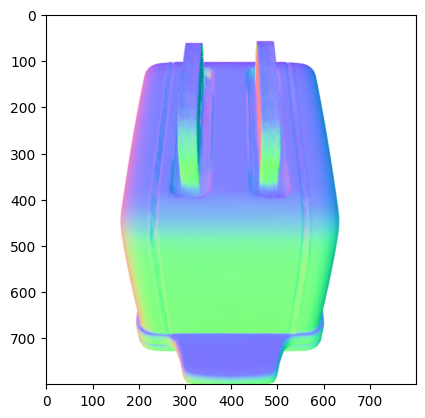

In [9]:
plt.imshow(normal_maps[0].cpu())

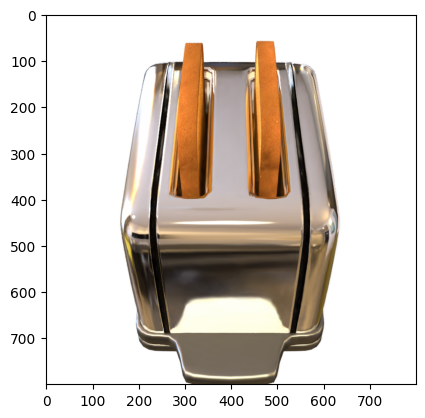

In [10]:
plt.imshow(ref_rgbs[0].cpu())

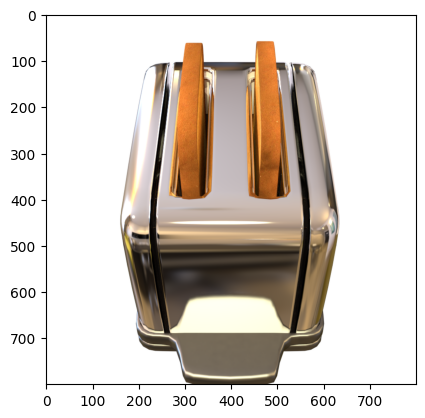

In [11]:
plt.imshow(gt_rgbs[0].cpu())

In [12]:
psnr_avg = 0.0
ssim_avg = 0.0
lpips_avg = 0.0

eval_num = len(dataset_test)

all_psnr = []
all_ssim = []
all_lpips = []

for i in tqdm(range(eval_num)):
    
    with torch.no_grad():
        img_gt_img = gt_rgbs[i].permute(2,0,1).to(device)
        my_albedo = ref_rgbs[i].permute(2,0,1).to(device)
        
        one_psnr = psnr(img_gt_img, my_albedo).mean()
        one_ssim = get_ssim(img_gt_img, my_albedo).mean()
        one_lpips = lpips_fn(img_gt_img, my_albedo).mean()
        
        psnr_avg += one_psnr
        ssim_avg += one_ssim
        lpips_avg += one_lpips
        
        all_psnr.append(one_psnr.item())
        all_ssim.append(one_ssim.item())
        all_lpips.append(one_lpips.item())
    
psnr_avg = psnr_avg / eval_num
ssim_avg = ssim_avg / eval_num
lpips_avg = lpips_avg / eval_num

MAE = 0
# for i in tqdm(range(len(scene.getTestCameras()))):
#     normal_gt_path = 'data/ref-real/'+NAME+'/test/r_'+ str(i)+'_normal.png'
#     normal_gt_img = Image.open(normal_gt_path)
    
#     normal_gt = np.array(normal_gt_img)[..., :3] / 255  # [H, W, 3] in range [0, 1]
#     normal_gt = (normal_gt - 0.5) * 2.0
#     normal_gt = normal_gt / np.linalg.norm(normal_gt, axis=-1, ord=2, keepdims=True)

#     normal_gs = normal_maps[i].numpy()
#     normal_gs = (normal_gs - 0.5) * 2.0
#     normal_gs = normal_gs / np.linalg.norm(normal_gs, axis=-1, ord=2, keepdims=True)
    
#     out = get_mae(normal_gt, normal_gs)
#     MAE += out
    
# MAE / len(scene.getTestCameras())

print("#", NAME, load_iteration, psnr_avg.item(), ssim_avg.item(), lpips_avg.item(), MAE / len(scene.getTestCameras()))

100%|██████████| 200/200 [00:10<00:00, 18.39it/s]

# toaster 30000 27.374462127685547 0.9505669474601746 0.06942307204008102 0.0


In [13]:
# import imageio
# rgb_video = "rgb.mp4"
# normal_video = "normal.mp4"

# imageio.mimwrite(rgb_video, ref_rgbs, fps=30, quality=9, macro_block_size=None)
# imageio.mimwrite(normal_video, normal_maps, fps=30, quality=9, macro_block_size=None)

In [14]:
# from IPython.display import Video
# Video(rgb_video, width=500)

In [15]:
# from IPython.display import Video
# Video(normal_video, width=500)